This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Load ODIM_H5 Volume data from German Weather Service

In this example, we obtain and read the latest available volumetric radar data from German Weather Service available at [opendata.dwd.de](https://opendata.dwd.de). Finally we do some plotting.

This retrieves the 10 sweeps (moments DBZH and VRADH) of the DWD volume scan of a distinct radar. This amounts to 20 data files which are combined into one volumetric Cf/Radial2 like xarray powered structure.

Exports to singel file Odim_H5 and Cf/Radial2 format are shown at the end of this tutorial.

In [1]:
import wradlib as wrl
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as pl
import numpy as np
import xarray as xr
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
from wradlib.io.xarray import CfRadial, OdimH5

In [2]:
import urllib3
import os
import io
import glob
import shutil

## Download Current Filelist from server

Import it into pandas DataFrame, export to list and sort it descending in time.

### Helper Class to parse response

In [3]:
from html.parser import HTMLParser

class DWDHTMLParser(HTMLParser):
    def handle_starttag(self, tag, attrs):
        if tag != 'a':
            return
        self.links.append(attrs[0][1])

parser = DWDHTMLParser()

In [4]:
radar = 'ESS'
DBZH = 'sweep_vol_z'
VRADH = 'sweep_vol_v'

import certifi
opendata_url1 = (f"https://opendata.dwd.de/weather/radar/sites/{DBZH}/{radar.lower()}/hdf5/")

http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
response = http.request('GET', opendata_url1).data.decode("utf-8")

parser.links = []
parser.feed(response)
filelist1 = parser.links[1:]

filelist1.sort(key=lambda x: x.split('-')[2])
filelist1.reverse()

opendata_url2 = (f"https://opendata.dwd.de/weather/radar/sites/{VRADH}/{radar.lower()}/hdf5/")

http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
response = http.request('GET', opendata_url2).data.decode("utf-8")

parser.links = []
parser.feed(response)
filelist2 = parser.links[1:]

filelist2.sort(key=lambda x: x.split('-')[2])
filelist2.reverse()

In [5]:
for f in filelist1[:10]:
    print(f)

ras07-vol5minng01_sweeph5onem_dbzh_09-2020061712240100-ess-10410-hd5
ras07-vol5minng01_sweeph5onem_dbzh_08-2020061712234800-ess-10410-hd5
ras07-vol5minng01_sweeph5onem_dbzh_07-2020061712233500-ess-10410-hd5
ras07-vol5minng01_sweeph5onem_dbzh_06-2020061712232100-ess-10410-hd5
ras07-vol5minng01_sweeph5onem_dbzh_05-2020061712230000-ess-10410-hd5
ras07-vol5minng01_sweeph5onem_dbzh_04-2020061712222900-ess-10410-hd5
ras07-vol5minng01_sweeph5onem_dbzh_03-2020061712220600-ess-10410-hd5
ras07-vol5minng01_sweeph5onem_dbzh_02-2020061712214300-ess-10410-hd5
ras07-vol5minng01_sweeph5onem_dbzh_01-2020061712212000-ess-10410-hd5
ras07-vol5minng01_sweeph5onem_dbzh_00-2020061712205700-ess-10410-hd5


In [6]:
for f in filelist2[:10]:
    print(f)

ras07-vol5minng01_sweeph5onem_vradh_09-2020061712240100-ess-10410-hd5
ras07-vol5minng01_sweeph5onem_vradh_08-2020061712234800-ess-10410-hd5
ras07-vol5minng01_sweeph5onem_vradh_07-2020061712233500-ess-10410-hd5
ras07-vol5minng01_sweeph5onem_vradh_06-2020061712232100-ess-10410-hd5
ras07-vol5minng01_sweeph5onem_vradh_05-2020061712230000-ess-10410-hd5
ras07-vol5minng01_sweeph5onem_vradh_04-2020061712222900-ess-10410-hd5
ras07-vol5minng01_sweeph5onem_vradh_03-2020061712220600-ess-10410-hd5
ras07-vol5minng01_sweeph5onem_vradh_02-2020061712214300-ess-10410-hd5
ras07-vol5minng01_sweeph5onem_vradh_01-2020061712212000-ess-10410-hd5
ras07-vol5minng01_sweeph5onem_vradh_00-2020061712205700-ess-10410-hd5


## Clean up local folder

In [7]:
flist = glob.glob('ras07*')
for f in flist:
    os.remove(f)

## Download latest volume to current directory

In [8]:
for f in filelist1[:10]:
    with http.request('GET', os.path.join(opendata_url1, f), preload_content=False) as r, open(f, 'wb') as out:       
        shutil.copyfileobj(r, out)

for f in filelist2[:10]:
    with http.request('GET', os.path.join(opendata_url2, f), preload_content=False) as r, open(f, 'wb') as out:       
        shutil.copyfileobj(r, out)        

## Read the files into xarray powered structure

In [9]:
flist = glob.glob('ras07*')
vol = wrl.io.OdimH5(flist, standard='cf', georef=True)

## Inspect structure
### Root Group

In [10]:
vol.root

<xarray.Dataset>
Dimensions:              (sweep: 10)
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2020-06-17T12:20:34Z'
    time_coverage_end    <U20 '2020-06-17T12:24:01Z'
    latitude             float64 51.41
    longitude            float64 6.967
    altitude             float64 185.1
    altitude_agl         float64 nan
    sweep_group_name     (sweep) <U8 'sweep_1' 'sweep_2' ... 'sweep_10'
    sweep_fixed_angle    (sweep) float64 12.0 4.499 1.5 ... 0.4999 17.0 7.998
    frequency            float64 nan
    status_xml           <U4 'None'
Attributes:
    Conventions:          Cf/Radial
    version:              H5rad 2.2
    title:                None
    institution:          WMO:10410,NOD:deess
    references:           None
    source:               None
    history:              None
    comment:              im/exported using wradlib
    instrument_name:      None
    site_name:            name of site where data were gathered
    scan_name:            name of scan strategy used, if applicable
    scan_id:              scan strategy id, if applicable. assumed 0 if missing
    platform_is_mobile:   "true" or "false", assumed "false" if missing
    ray_times_increase:   "true" or "false", assumed "true" if missing. This ...
    field_names:          array of strings of field names present in this file.
    time_coverage_start:  copy of time_coverage_start global variable
    time_coverage_end:    copy of time_coverage_end global variable
    simulated data:       "true" or "false", assumed "false" if missing. data...
    instrument:           WMO:10410,NOD:deess

In [11]:
vol.root.sweep_fixed_angle

<xarray.DataArray 'sweep_fixed_angle' (sweep: 10)>
array([12.00256348,  4.49890137,  1.49963379,  3.49914551, 24.99938965,
        2.49938965,  5.49865723,  0.49987793, 17.00134277,  7.99804688])
Dimensions without coordinates: sweep

### Sweep Groups

In [12]:
list(vol)

['sweep_1',
 'sweep_2',
 'sweep_3',
 'sweep_4',
 'sweep_5',
 'sweep_6',
 'sweep_7',
 'sweep_8',
 'sweep_9',
 'sweep_10']

In [13]:
vol['sweep_1']

<xarray.Dataset>
Dimensions:       (range: 60, time: 360)
Coordinates:
    sweep_mode    <U20 'azimuth_surveillance'
    latitude      float64 51.41
    altitude      float64 185.1
    longitude     float64 6.967
    elevation     (time) float64 12.03 12.03 12.03 12.03 ... 12.03 12.03 12.03
    azimuth       (time) float64 0.5109 1.527 2.521 3.51 ... 357.5 358.5 359.5
  * range         (range) float32 500.0 1500.0 2500.0 ... 58500.0 59500.0
    y             (time, range) float64 489.0 1.467e+03 ... 5.713e+04 5.81e+04
    z             (time, range) float64 289.2 497.6 ... 1.257e+04 1.279e+04
    gr            (time, range) float64 489.0 1.467e+03 ... 5.713e+04 5.811e+04
    rays          (time, range) float64 0.5109 0.5109 0.5109 ... 359.5 359.5
    bins          (time, range) float32 500.0 1500.0 2500.0 ... 58500.0 59500.0
    x             (time, range) float64 4.36 13.08 21.8 ... -487.2 -495.7 -504.2
  * time          (time) datetime64[ns] 2020-06-17T12:23:29.888000 ... 2020-06-17T12:23:29.854500096
Data variables:
    VRADH         (time, range) float32 ...
    sweep_number  int64 0
    follow_mode   <U4 'none'
    prt_mode      <U5 'fixed'
    fixed_angle   float64 12.0
    DBZH          (time, range) float32 ...

## plot sweeps
### DBZH

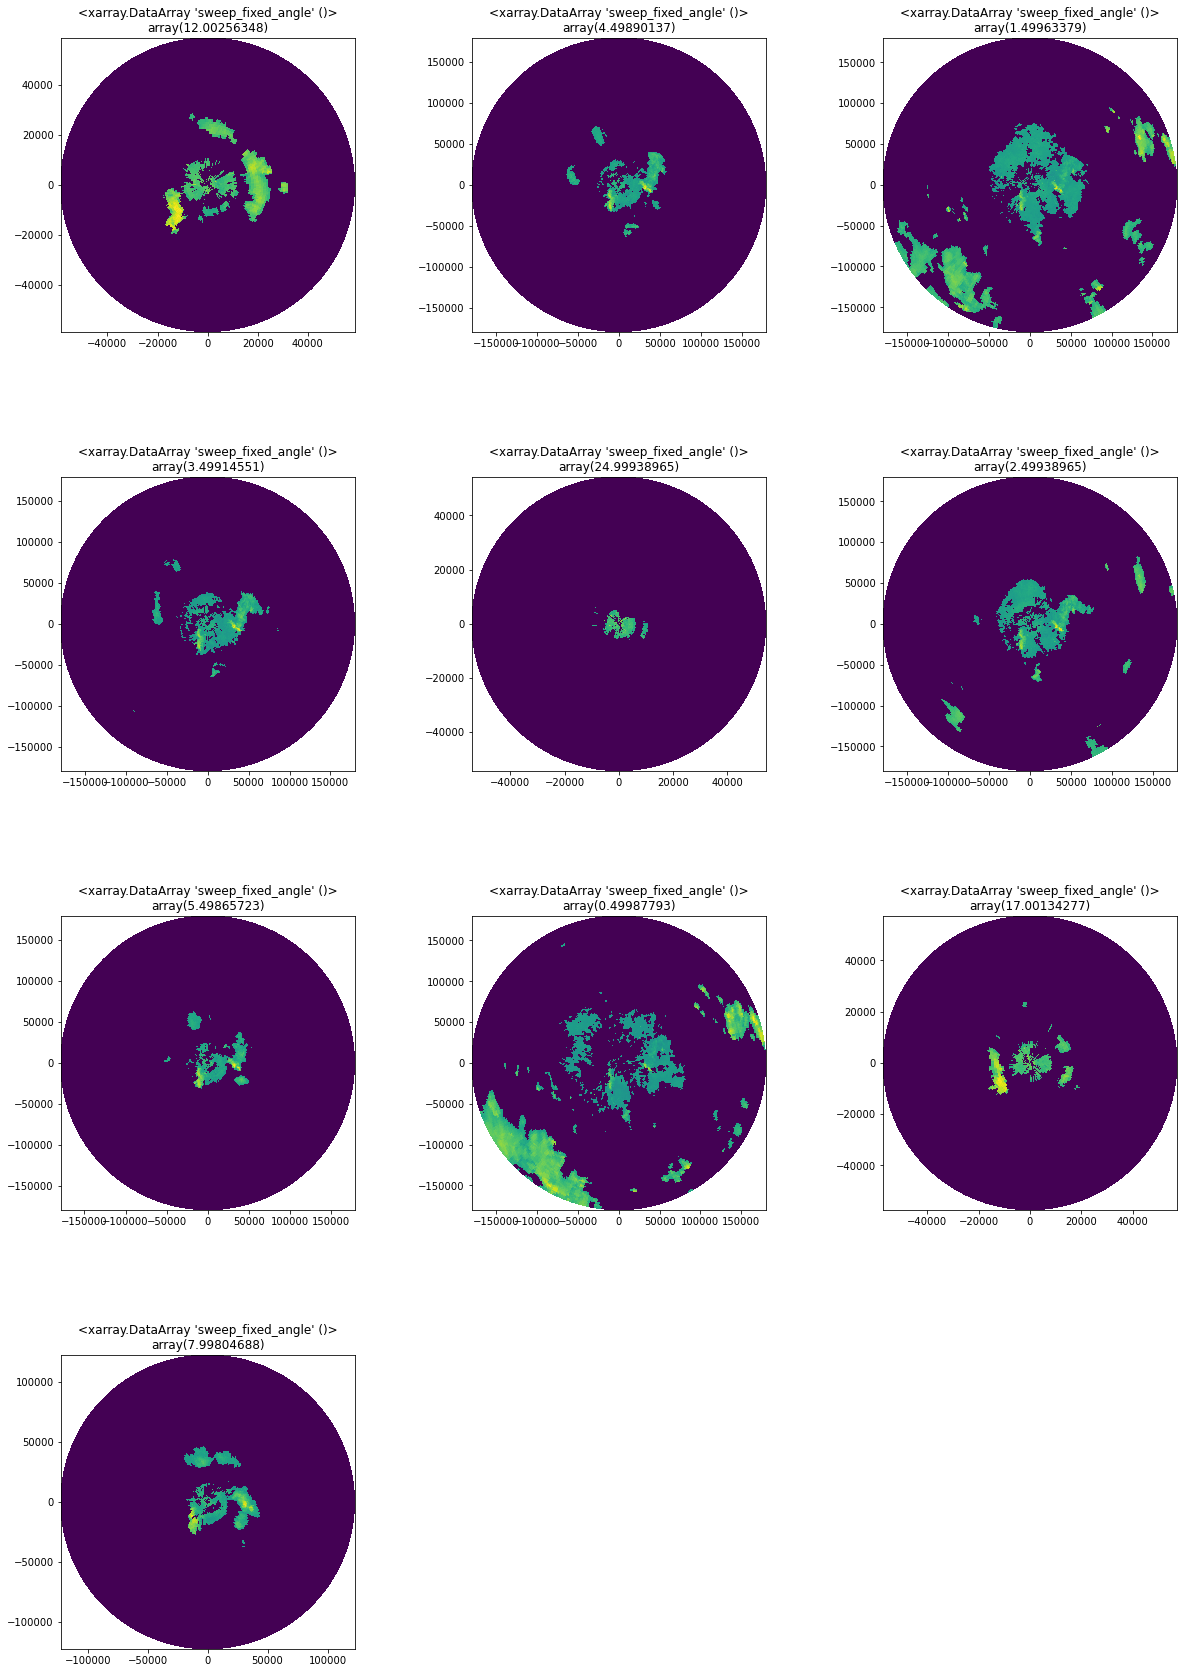

In [14]:
fig = pl.figure(figsize=(20, 30))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(4, 3, wspace=0.4, hspace=0.4)
for i, swp in enumerate(vol.values()):
    swp.DBZH.wradlib.plot(ax=gs[i], fig=fig)
    ax = pl.gca()
    ax.set_title(vol.root.sweep_fixed_angle[i])

### VRADH

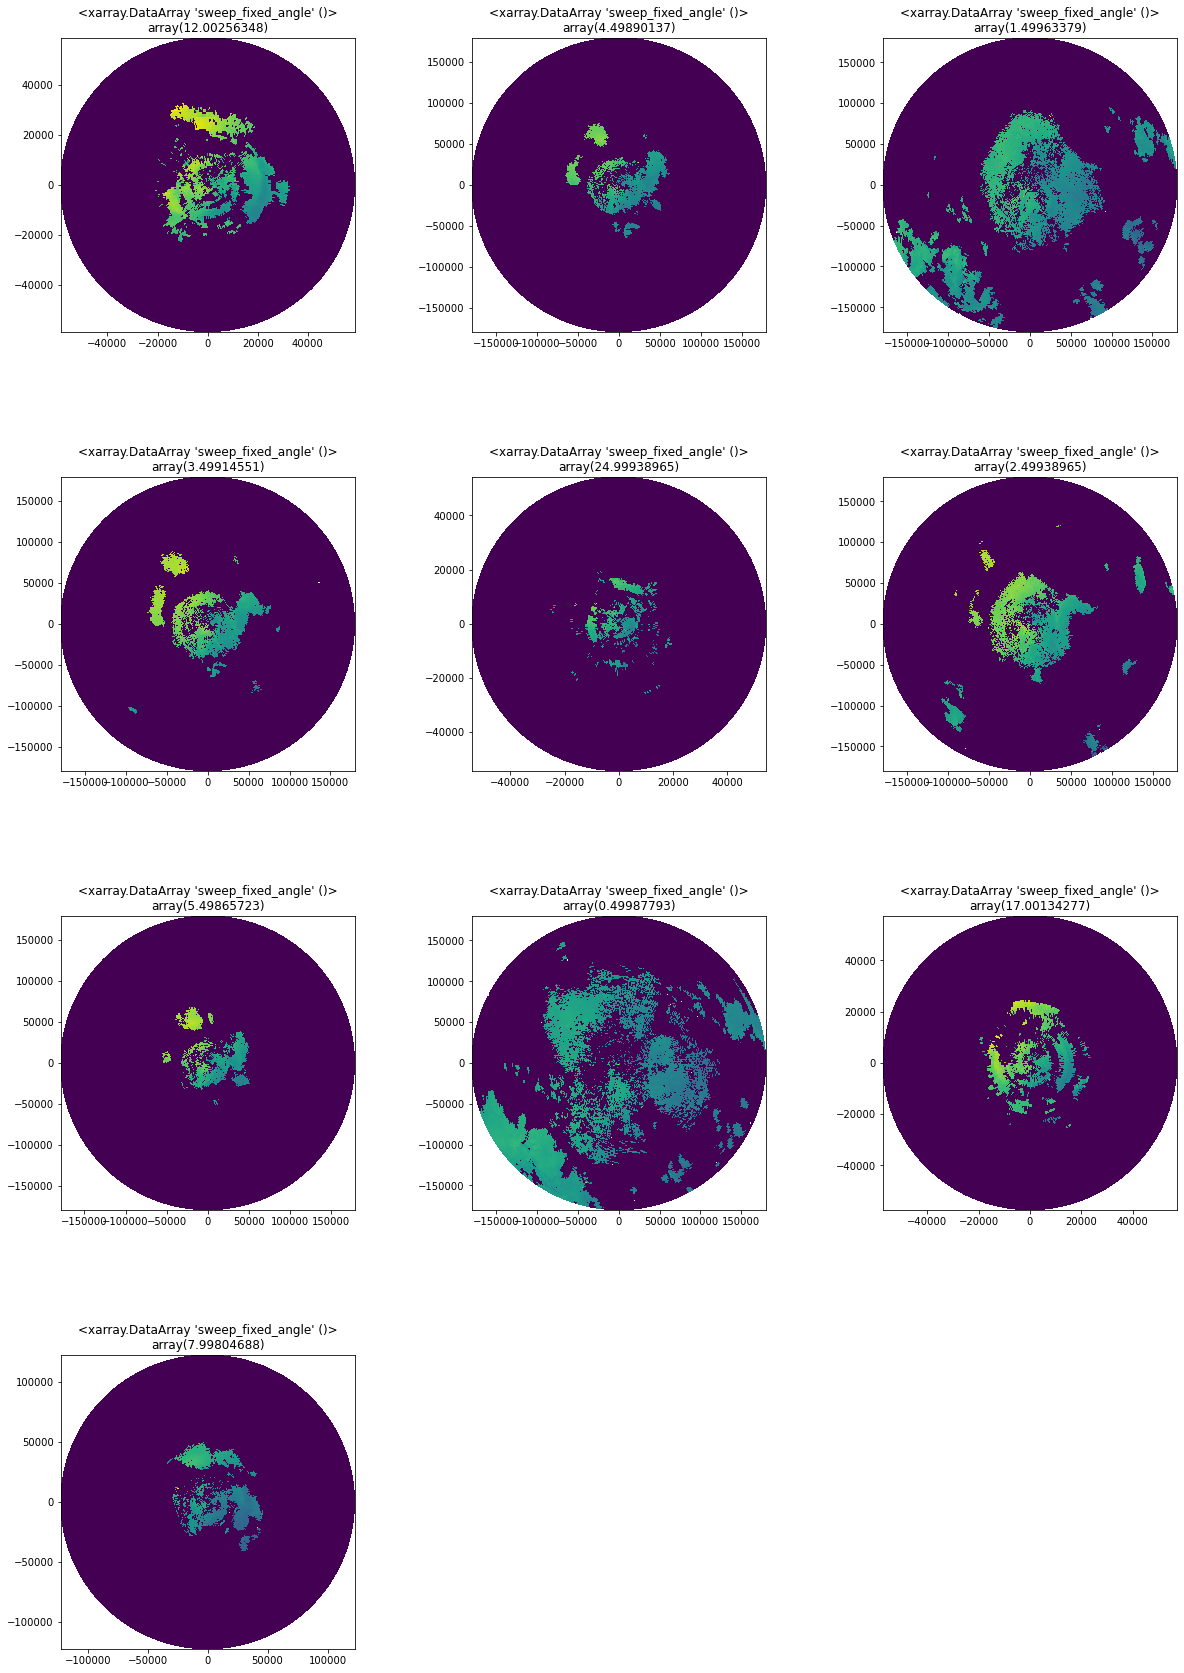

In [15]:
fig = pl.figure(figsize=(20, 30))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(4, 3, wspace=0.4, hspace=0.4)
for i, swp in enumerate(vol.values()):
    swp.VRADH.wradlib.plot(ax=gs[i], fig=fig)
    ax = pl.gca()
    ax.set_title(vol.root.sweep_fixed_angle[i])

### Plot single sweep using cartopy

In [16]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

map_trans = ccrs.AzimuthalEquidistant(central_latitude=vol['sweep_10'].latitude.values, 
                                      central_longitude=vol['sweep_10'].longitude.values)

< GeoAxes: <cartopy.crs.AzimuthalEquidistant object at 0x7fcfe1d552c0> >


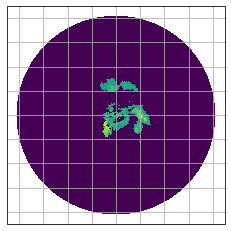

In [17]:
map_proj = ccrs.AzimuthalEquidistant(central_latitude=vol['sweep_10'].latitude.values, 
                                      central_longitude=vol['sweep_10'].longitude.values)
pm = vol['sweep_10'].DBZH.wradlib.plot_ppi(proj=map_proj)
ax = pl.gca()
ax.gridlines(crs=map_proj)
print(ax)

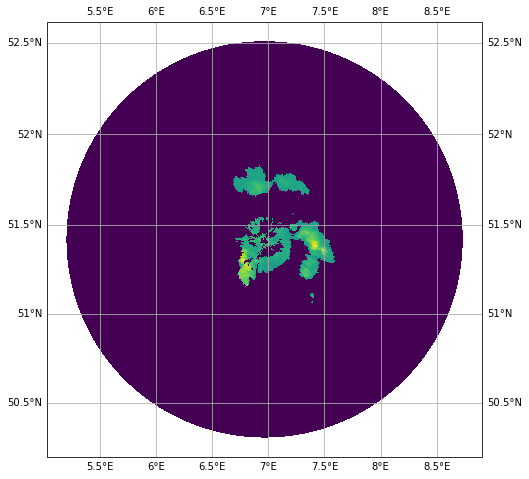

In [18]:
map_proj = ccrs.Mercator(central_longitude=vol['sweep_10'].longitude.values)
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection=map_proj)
pm = vol['sweep_10'].DBZH.wradlib.plot_ppi(ax=ax)
ax.gridlines(draw_labels=True)

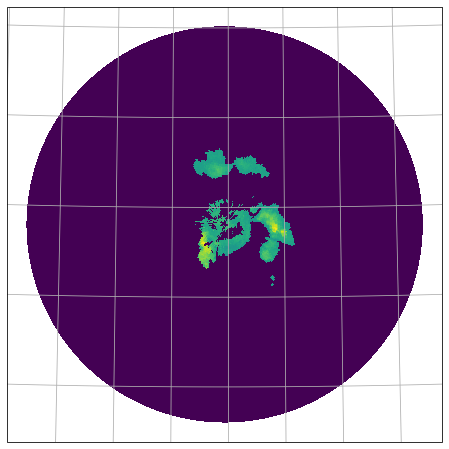

In [19]:
fig = pl.figure(figsize=(10, 8))
proj=ccrs.AzimuthalEquidistant(central_latitude=vol['sweep_10'].latitude.values, 
                               central_longitude=vol['sweep_10'].longitude.values)
ax = fig.add_subplot(111, projection=proj)
pm = vol['sweep_10'].DBZH.wradlib.plot_ppi(ax=ax)
ax.gridlines()

### Inspect radar moments

The dataarrays can be accessed by key or by attribute. Each dataarray has the datasets dimensions and coordinates of it's parent dataset. There are attributes connected which are defined by Cf/Radial and/or ODIM_H5 standard.

In [20]:
vol['sweep_10'].DBZH

<xarray.DataArray 'DBZH' (time: 360, range: 124)>
array([[-64.00293 , -64.00293 ,   2.451286, ..., -64.00293 , -64.00293 ,
        -64.00293 ],
       [-64.00293 ,   6.664368,   3.406403, ..., -64.00293 , -64.00293 ,
        -64.00293 ],
       [-64.00293 ,  13.004501,   6.576469, ..., -64.00293 , -64.00293 ,
        -64.00293 ],
       ...,
       [-64.00293 , -64.00293 ,   2.237404, ..., -64.00293 , -64.00293 ,
        -64.00293 ],
       [-64.00293 , -64.00293 , -64.00293 , ..., -64.00293 , -64.00293 ,
        -64.00293 ],
       [-64.00293 , -64.00293 , -64.00293 , ..., -64.00293 , -64.00293 ,
        -64.00293 ]], dtype=float32)
Coordinates:
    sweep_mode  <U20 'azimuth_surveillance'
    latitude    float64 51.41
    altitude    float64 185.1
    longitude   float64 6.967
    elevation   (time) float64 8.02 8.02 8.02 8.02 8.02 ... 8.02 8.02 8.02 8.02
    azimuth     (time) float64 0.5219 1.524 2.516 3.521 ... 357.5 358.5 359.5
  * range       (range) float32 500.0 1500.0 2500.0 ... 122500.0 123500.0
    y           (time, range) float64 495.1 1.485e+03 ... 1.21e+05 1.22e+05
    z           (time, range) float64 254.7 394.2 534.2 ... 1.814e+04 1.829e+04
    gr          (time, range) float64 495.1 1.485e+03 ... 1.21e+05 1.22e+05
    rays        (time, range) float64 0.5219 0.5219 0.5219 ... 359.5 359.5 359.5
    bins        (time, range) float32 500.0 1500.0 2500.0 ... 122500.0 123500.0
    x           (time, range) float64 4.509 13.53 ... -1.039e+03 -1.047e+03
  * time        (time) datetime64[ns] 2020-06-17T12:23:14.836000 ... 2020-06-17T12:23:14.780000
Attributes:
    standard_name:  radar_equivalent_reflectivity_factor_h
    long_name:      Equivalent reflectivity factor H
    units:          dBZ

In [21]:
vol['sweep_10'].sweep_mode

<xarray.DataArray 'sweep_mode' ()>
array('azimuth_surveillance', dtype='<U20')
Coordinates:
    sweep_mode  <U20 'azimuth_surveillance'
    latitude    float64 51.41
    altitude    float64 185.1
    longitude   float64 6.967

In [22]:
vol.root

<xarray.Dataset>
Dimensions:              (sweep: 10)
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2020-06-17T12:20:34Z'
    time_coverage_end    <U20 '2020-06-17T12:24:01Z'
    latitude             float64 51.41
    longitude            float64 6.967
    altitude             float64 185.1
    altitude_agl         float64 nan
    sweep_group_name     (sweep) <U8 'sweep_1' 'sweep_2' ... 'sweep_10'
    sweep_fixed_angle    (sweep) float64 12.0 4.499 1.5 ... 0.4999 17.0 7.998
    frequency            float64 nan
    status_xml           <U4 'None'
Attributes:
    Conventions:          Cf/Radial
    version:              H5rad 2.2
    title:                None
    institution:          WMO:10410,NOD:deess
    references:           None
    source:               None
    history:              None
    comment:              im/exported using wradlib
    instrument_name:      None
    site_name:            name of site where data were gathered
    scan_name:            name of scan strategy used, if applicable
    scan_id:              scan strategy id, if applicable. assumed 0 if missing
    platform_is_mobile:   "true" or "false", assumed "false" if missing
    ray_times_increase:   "true" or "false", assumed "true" if missing. This ...
    field_names:          array of strings of field names present in this file.
    time_coverage_start:  copy of time_coverage_start global variable
    time_coverage_end:    copy of time_coverage_end global variable
    simulated data:       "true" or "false", assumed "false" if missing. data...
    instrument:           WMO:10410,NOD:deess

In [23]:
#vol.root = vol.root.assign(longitude=vol.root.longitude[0])
#vol.root = vol.root.assign(latitude=vol.root.latitude[0])
#vol.root = vol.root.assign(altitude=vol.root.altitude[0])

## Export to OdimH5

This exports the radar volume including all moments into one ODIM_H5 compliant data file.

In [24]:
vol.to_odim('dwd_odim.h5')

## Export to Cf/Radial2

This exports the radar volume including all moments into one Cf/Radial2 compliant data file.

In [25]:
vol.to_cfradial2('dwd_cfradial2.nc')

## Import again and check equality

Small time differences are possible so drop times before comparison

In [26]:
try:
    vol1 = OdimH5('dwd_odim.h5', standard='cf', georef=True)
    vol2 = CfRadial('dwd_cfradial2.nc', dim0='azimuth', georef=True)
    xr.testing.assert_equal(vol1.root, vol2.root)
    xr.testing.assert_equal(vol1['sweep_1'].drop('time'), vol2['sweep_1'].drop('time'))
except:
    pass